In [7]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest # RFECV, 
from sklearn.metrics import r2_score, root_mean_squared_error

from sklearn import set_config
from FunctionsML import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
#from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.tree import plot_tree

In [9]:
%matplotlib inline

# Loading Data
- The data is from a Kaggle competition and contains 80 metrics describing housing prices
- The SalePrice is the target feature and should be forcast via a supervised Machine Learning
  Algorithm

In [11]:
df = pd.read_csv('Data/housing_iteration_6_regression.csv')
df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
586,587,30,RL,55.0,10267,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Norm,1Fam,1Story,6,7,1918,2000,Gable,CompShg,Stucco,Wd Shng,NaN,0.0,TA,Gd,BrkTil,TA,Gd,Mn,Rec,210,ALQ,606,0,816,GasA,Ex,Y,SBrkr,838,0,0,838,1,0,1,0,2,1,Fa,5,Typ,0,NaN,Detchd,1961.0,Fin,1,275,TA,TA,N,0,0,112,0,0,0,NaN,MnWw,NaN,0,5,2008,WD,Normal,130000
430,431,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,BrkFace,232.0,TA,TA,CBlock,TA,TA,No,ALQ,387,Unf,0,96,483,GasA,TA,Y,SBrkr,483,504,0,987,0,0,1,1,2,1,TA,4,Typ,0,NaN,Detchd,1971.0,Unf,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2008,COD,Abnorml,85400
869,870,60,RL,80.0,9938,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,MetalSd,MetalSd,BrkFace,246.0,Gd,TA,PConc,Gd,TA,No,GLQ,750,Unf,0,300,1050,GasA,Ex,Y,SBrkr,1062,887,0,1949,1,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1993.0,Fin,2,574,TA,TA,Y,156,90,0,0,0,0,NaN,GdPrv,NaN,0,6,2010,WD,Normal,236000
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
1391,1392,90,RL,65.0,8944,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,5,1967,1967,Gable,CompShg,Plywood,Plywood,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1584,1584,GasA,TA,Y,SBrkr,1584,0,0,1584,0,0,2,0,4,2,TA,8,Mod,0,NaN,Detchd,1967.0,Unf,3,792,TA,TA,Y,0,152,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,124000


# Data Cleaning

In [7]:
# get rid of 10 strange entries in MSZoning
df.loc[df['MSZoning'] == 'C (all)','MSZoning'] = 'NA'

# Preprocessing
- First, a test train split is performed (**X_train, X_test, y_train, y_test**),
  20% of the data is used as test data
- Numerical and categorical features are splitted (**X_cat, X_num**)
- 1.1) Numerical Pipe
  The numerical data is treated with a SimpleImputer to get rid of NaNs,
  if imputing the mean or median values is tested later, **numerical_pipe**
- 1.2) Categorical Pipe
  - The ordinal categorical data is transformed with an ordinal encoder and
    the remaining data with an one-hot encoder, the whole CollumnTransformer is
    called **cat_encoder**
  - The categorical data is treated with a SimpleImputer as well
  - The cat_encoder and the SimpleImputer form the **categoric_pipe**
- 1.3) The numerical_pip and the categoric_pipe form the **preprocessor**

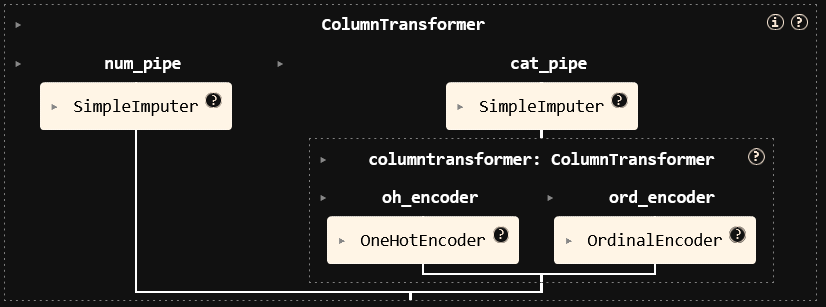
  
  

In [168]:
# creating a dict to save scores
scores = {}

# seperate prediction- and target features
X = df.copy() # prediction features
X = X.set_index('Id') # the ID is used as index
y = X.pop('SalePrice') # target features

# perform the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1230)

# 1) Built Preprocessor
# seperate categorical and numerical data
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 1.1) create numerical pipeline, only with the SimpleImputer, the strategy is scanned later
numeric_pipe = make_pipeline(
    SimpleImputer()
)

In [169]:
# 1.2) create categorical pipeline

# Setting up the ordinal encoder
set_config(transform_output='pandas')
# define ordinal features
ord_feat = ['ExterQual',
            'ExterCond',
            'MSZoning',  # keep an eye on it, because maybe its the wrong order, but this seems to be an important metric
            'LotShape',  # new
            'Utilities', # new
            'LandSlope', # new
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure', # seems important
            'BsmtFinType1',
            'BsmtFinType2', # new
            'HeatingQC',
            'CentralAir', # seems important
            'KitchenQual',
            'FireplaceQu',
            #'GarageType', # new, keep an eye on it, maybe wrong order
            'GarageFinish', # new
            'GarageQual',
            'GarageCond', # new
            'PavedDrive', # new
            'PoolQC',
            'Fence']

# Create ordered categories of all features
# All orders must include the cat_imputer's fill_value so missing values can be encoded
ex_to_po = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

# Category orders for each ordinal feature
ExterQual = ex_to_po
ExterCond = ex_to_po
MSZoning = ['FV','RL','RP','RH','RM','C','A', 'I', 'NA']
LotShape = ['IR3','IR2','IR1','Reg','NA']
Utilities = ['AllPub','NoSewr','NoSeWa','ELO','NA']
LandSlope = ['Sev','Mod','Gtl','NA']
BsmtQual = ex_to_po
BsmtCond = ex_to_po
BsmtExposure = ['Gd', 'Av', 'Mn', 'No', 'NA']     
BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC = ex_to_po
CentralAir = ['Y','N','NA']
KitchenQual = ex_to_po
FireplaceQu = ex_to_po
#GarageType = ['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd','NA']
GarageFinish =['Fin','RFn','Unf','NA']
GarageQual = ex_to_po
GarageCond = ex_to_po
PavedDrive =['Y', 'P', 'N', 'NA']
PoolQC = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
Fence = ['GdPrv','MnPrv','GdWo','MnWw','NA']

# List of all orders
category_orders = [ExterQual,
                   ExterCond,
                   MSZoning,  # keep an eye on
                   LotShape, # new
                   Utilities, # new
                   LandSlope, #new
                   BsmtQual,
                   BsmtCond,
                   BsmtExposure,
                   BsmtFinType1,
                   BsmtFinType2, # new
                   HeatingQC,
                   CentralAir,
                   KitchenQual,
                   FireplaceQu,
                   # GarageType, # new keep an eye on
                   GarageFinish,
                   GarageQual,
                   GarageCond, # new
                   PavedDrive, # new
                   PoolQC,
                   Fence]

# Initializing ordinal encoder
ord_encoder = OrdinalEncoder(categories=category_orders)


# Defining all remaining features to be treated with a one-hot encoder
oh_feat = list(set(X_cat)-set(ord_feat)) # one hot features

# Initializing one-hot encoder
oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', # min_frequency determined in grid
                           sparse_output=False) # must be false now that we've set_config to pandas

# full categorical encoder 
cat_encoder = ColumnTransformer(
    transformers=[
    ('oh_encoder', oh_encoder, oh_feat),
    ('ord_encoder', ord_encoder, ord_feat)
    ], verbose_feature_names_out=False) # this is just for plotting the tree
cat_encoder

ColumnTransformer(transformers=[('oh_encoder',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['Electrical', 'RoofMatl', 'MasVnrType',
                                  'HouseStyle', 'GarageType', 'RoofStyle',
                                  'Condition2', 'MiscFeature', 'Exterior1st',
                                  'Alley', 'Heating', 'Functional', 'SaleType',
                                  'LandContour', 'Foundation', 'Street',
                                  'Condition1', 'Exterior2nd', 'Neighborh...
                                                            ['Ex', 'Gd', 'TA',
                                                             'Fa', 'NA'],
                                                            ['GdPrv', 'MnPrv',
                                                             'GdWo', 'MnWw',
                                                             'NA']]),
                                 ['ExterQual', 'ExterCond', 'MSZoning',
                                  'LotShape', 'Utilities', 'LandSlope',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'CentralAir', 'KitchenQual', 'FireplaceQu',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'PavedDrive', 'PoolQC', 'Fence'])],
                  verbose_feature_names_out=False)

In [170]:
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") 
# and the OneHotEncoder

categoric_pipe = make_pipeline(
                SimpleImputer(fill_value="NA"),  # fill missing data with 'NA'
                cat_encoder
)

# initialize the make_column_transformer to split into branches
preprocessor = ColumnTransformer(
    transformers=[
    ('num_pipe', numeric_pipe, X_num.columns),
    ('cat_pipe', categoric_pipe, X_cat.columns),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

In [171]:
# # make a report
# from ydata_profiling import ProfileReport 	
# report = ProfileReport(pd.concat([X_train,y_train],axis=1)) 	
# report.to_file('report_regression.html')

# Different Algorithms
- Regression performance is tested with different algorithms
  Decision tree, Random Forest
- The hyperparameter space is always tested with a 5-fold Cross Validation
  using GridSearchCV.  For scoring 'neg_root_mean_squared_log_error'
  is used, as this is the parameter scanned for in the Kaggle competition
- The parameter grid used, is the result of thorough parameter testing, the
  starting parameters are left in the code.


## Decision tree

In [432]:
# import DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor
from numpy import arange # this allows you to make ranges with floats

# create full pipeline with the preprocessor and the decision tree
dt_pipe = make_pipeline(preprocessor,
                              DecisionTreeRegressor(random_state=123))

dt_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Bsm...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=123))])

In [444]:
# Defining the cross validation

# good start: 
# dt_param_grid = {
#     'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'decisiontreeregressor__max_depth': range(2, 15, 2),  
#     'decisiontreeregressor__min_samples_leaf': range(5,30,3), 
#     'decisiontreeregressor__min_impurity_decrease':arange(0.1, 0.5, 0.2), 
#     'decisiontreeregressor__ccp_alpha':[10**e for e in range(-4, 0)] + [0] 
# }

dt_param_grid = {
    'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], 
    'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
    'decisiontreeregressor__max_depth': range(13, 16, 1), 
    'decisiontreeregressor__min_samples_leaf': range(13,16,1), 
    'decisiontreeregressor__min_impurity_decrease':arange(0.1, 0.5, 0.1),  
    'decisiontreeregressor__ccp_alpha': [0] + [10**e for e in range(-7, -4)]
}

# Initalize the GridSearch
dt_search = GridSearchCV(dt_pipe, # you have defined this beforehand
                      dt_param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='neg_root_mean_squared_log_error', # the performance metric to use,
                      n_jobs=-1, # uses all CPU cores, slows down other applications
                      verbose=1) # controls output

# Fit your parameter grid to the training data, %time stops time
%time dt_search.fit(X_train, y_train)

# Use model to predict training data
dt_r2 = r2_score(y_train, dt_search.predict(X_train))
print('The r2_score for the training data is: ', round(dt_r2,2))
dt_rmse = root_mean_squared_error(y_train, dt_search.predict(X_train))
print('The rmse for the training data is: ', round(dt_rmse,2))
# best parameters
print('The best parameters are: ')
dt_search.best_params_

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits
CPU times: total: 3min 39s
Wall time: 6min 51s
The r2_score for the training data is:  0.86
The rmse for the training data is:  29710.6
The best parameters are: 


{'columntransformer__cat_pipe__simpleimputer__strategy': 'most_frequent',
 'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'decisiontreeregressor__ccp_alpha': 0,
 'decisiontreeregressor__max_depth': 12,
 'decisiontreeregressor__min_impurity_decrease': 0.1,
 'decisiontreeregressor__min_samples_leaf': 14}

In [435]:
# Use model to predict testing data
dt_score = root_mean_squared_error(y_test, dt_search.predict(X_test))
print('The rsme for the testing data is: ', round(dt_score,2))

# save score to dictionary
scores['DecisionTree'] = dt_score

The rsme for the testing data is:  36537.86


# K nearest neighbours
* requires scaling
* highly sensitve to feature selection
* slow prediction, fast fitting
* Principal component analysis can be implemented into the pipeline

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'standardscaler': As the KNN regressor needs scaling, different scaling methods are tested,
  the standard and the robust scaler are found to be most promising
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'knn': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [343]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

knn_pipe= Pipeline([('preprocessor',preprocessor),
                    ('standardscaler',StandardScaler()),
                    ('feature', 'passthrough'),#
                    ('pca','passthrough'), # PCA(), #PCA should be done after scaling
                    ('knn',KNeighborsRegressor()),
])
                                
knn_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFull...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('feature', 'passthrough'), ('pca', 'passthrough'),
                ('knn', KNeighborsRegressor())])

In [ ]:
# History of parameter grids to show what was changes along the way

## good starting values and all options apart from the feature selection
# knn_param_grid = {
#     'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'],
#     'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'],
#     'standardscaler': ['passthrough', StandardScaler(), RobustScaler(), MinMaxScaler()],   # possible scalers
#     'pca':['passthrough',PCA()],       # no PCA or PCA
#     'pca__n_components': range(3, 10),                                  

#     'kneighborsregressor__n_neighbors': range(3, 10),                    #  up to 50 for large datasets
#     'kneighborsregressor__weights': ['uniform','distance'],              
#     'kneighborsregressor__p':range(1,5,1)                                
# }

# # param grid for feature selection with SelectFromModel using a Decision Tree
# knn_param_grid = {
#     'preprocessor__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], 
#     'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'standardscaler': [StandardScaler(), RobustScaler()], 
    
#     'feature':[SelectFromModel(DecisionTreeRegressor(random_state=123))],
    
#     'knn__n_neighbors': range(8,12,1),                   
#     'knn__weights': ['distance','uniform'],        
#     'knn__p': arange(1,2,0.5)
# }
# # param grid for SelectKBest, test f_regression and mutual_info_regression
# knn_param_grid = {
#     'preprocessor__cat_pipe__simpleimputer__strategy':['constant'],
#     'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'standardscaler': [StandardScaler(), RobustScaler()],
    
#     'feature':[SelectKBest()], 
#     'feature__score_func': [f_regression, mutual_info_regression], 
#     'feature__k':range(15,17,1),

#     'knn__n_neighbors': range(12,15,1), 
#     'knn__weights': ['distance'],
#     'knn__p': arange(1.3,1.9,0.2)
# } 

In [379]:
# Training of the algorithm
# final param grid for SelectKBest with mutual_info_regression
knn_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['constant'], 
    'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
    'standardscaler': [StandardScaler(), RobustScaler()],  
    
    'feature':[SelectKBest()], 
    'feature__score_func': [mutual_info_regression], # 
    'feature__k':range(16,22,1),
   
    'knn__n_neighbors': range(12,15,1),                   
    'knn__weights': ['distance'],             
    'knn__p': arange(1.2,1.6,0.1) 
}                                                                  
# initialiing the Cross Validation
knn_search = GridSearchCV(knn_pipe,
                          knn_param_grid,
                          cv=5,
                          scoring='neg_root_mean_squared_log_error',
                          verbose=1,
                          n_jobs=-1)

%time knn_search.fit(X_train, y_train)
# best parameters
print('The best score is: ', round(knn_search.best_score_,3))
# best parameters
print('The best parameters are: ')
knn_search.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
CPU times: total: 16.2 s
Wall time: 5min 38s
The best score is:  -0.163
The best parameters are: 


{'feature': SelectKBest(),
 'feature__k': 17,
 'feature__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'knn__n_neighbors': 12,
 'knn__p': 1.2,
 'knn__weights': 'distance',
 'preprocessor__cat_pipe__simpleimputer__strategy': 'constant',
 'preprocessor__num_pipe__simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [382]:
# show best parameters
test = show_best(knn_search,25)
print('the result is:', test['mean_test_score'].mean(), '+-' , test['mean_test_score'].std())

the result is: -0.1643257956727635 +- 0.000383481090820969


In [390]:
# show results of best 25 folds by using the function show_best to identify how
# meaningful the parameters are
show_best(knn_search,25)#.sort_values('param_knn n_neighbors')#.sort_values('param_feature k')#

,param_feature,param_feature k,param_feature score_func,param_knn n_neighbors,param_knn p,param_knn weights,simpleimputer strategy,simpleimputer strategy,param_standardscaler,mean_test_score,rank_test_score
60,SelectKBest(),17,<function mutual_info_regression at 0x00000142...,12,1.2,distance,constant,mean,StandardScaler(),-0.163248,1
64,SelectKBest(),17,<function mutual_info_regression at 0x00000142...,12,1.3,distance,constant,mean,StandardScaler(),-0.163652,2
340,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,14,1.2,distance,constant,mean,StandardScaler(),-0.163714,3
300,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,12,1.2,distance,constant,mean,StandardScaler(),-0.163787,4
301,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,12,1.2,distance,constant,mean,RobustScaler(),-0.164086,5
308,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,12,1.4,distance,constant,mean,StandardScaler(),-0.164172,6
304,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,12,1.3,distance,constant,mean,StandardScaler(),-0.164211,7
100,SelectKBest(),17,<function mutual_info_regression at 0x00000142...,14,1.2,distance,constant,mean,StandardScaler(),-0.164273,8
320,SelectKBest(),21,<function mutual_info_regression at 0x00000142...,13,1.2,distance,constant,mean,StandardScaler(),-0.164361,9
120,SelectKBest(),18,<function mutual_info_regression at 0x00000142...,12,1.2,distance,constant,mean,StandardScaler(),-0.164362,10


In [290]:
# Use model to predict testing data
knn_score = root_mean_squared_error(y_test, knn_search.predict(X_test))
print('The rsme for the testing data is: ', round(knn_score,2))
knn_score = r2_score(y_test, knn_search.predict(X_test))
print('The r2 for the testing data is: ', round(knn_score,2))
# save score to dictionary
scores['Knn'] = knn_score

The rsme for the testing data is:  31685.85
The r2 for the testing data is:  0.85


In [292]:
# find the most important parameters
knn_search.best_estimator_.named_steps['knn'].feature_names_in_

array(['num_pipe__OverallQual', 'num_pipe__YearBuilt',
       'num_pipe__YearRemodAdd', 'num_pipe__TotalBsmtSF',
       'num_pipe__1stFlrSF', 'num_pipe__GrLivArea', 'num_pipe__FullBath',
       'num_pipe__TotRmsAbvGrd', 'num_pipe__GarageCars',
       'num_pipe__GarageArea', 'cat_pipe__ExterQual',
       'cat_pipe__BsmtQual', 'cat_pipe__KitchenQual',
       'cat_pipe__FireplaceQu', 'cat_pipe__GarageFinish'], dtype=object)

# Random Forest
* tradeoff between performance vs training time (start with few fits)
* robust to overfitting
* no scaling
* Random forests benefit from feature selection but can still tolerate high numbers of features.
  Unlike KNN, features that only have a little information can still be utilized by random forests.

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'standardscaler': As the KNN regressor needs scaling, different scaling methods are tested,
  the standard and the robust scaler are found to be most promising
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'knn': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [414]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = make_pipeline(preprocessor,
                                 StandardScaler(),
                                 SelectKBest(score_func=mutual_info_regression,k=17), #SelectFromModel(DecisionTreeRegressor(random_state=123))
                                 RandomForestRegressor())
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Bsm...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

knn_pipe= Pipeline([('preprocessor',preprocessor),
                    ('standardscaler',StandardScaler()),
                    ('feature', 'passthrough'),#
                    ('pca','passthrough'), #PCA(), #PCA should be done after scaling
                    ('knn',KNeighborsRegressor()),
])
                                
knn_pipe

In [ ]:
# Due to time constrains only a broad parameter search performed
rf_param_grid = {
    'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], # 'constant','most_frequent'
    'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
    'standardscaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'randomforestregressor__n_estimators': range(50, 210, 50), #(dataset very small) #7 options
    'randomforestregressor__max_depth': [9,12,15],        #6 optionsrange(3, 7, 1)
    'randomforestregressor__min_samples_leaf': [2,5,8],  #5 optionsarange(0, 0.0011, 0.0002)
    #'randomforestregressor__ccp_alpha': arange(0., 0.01, 0.0025)#[10**e for e in range(-5, -1)]                #4 options
}    


rf_search = GridSearchCV(rf_pipe,
                         rf_param_grid,
                         cv=5, 
                         scoring='neg_root_mean_squared_log_error', #'neg_root_mean_squared_log_error',
                         verbose=1,
                         n_jobs=-1) # especially important for random forest

%time rf_search.fit(X_train, y_train)

In [492]:
print('The best score is: ', round(rf_search.best_score_,3))
print('The best parameters are: ')
rf_search.best_params_

The best score is:  -0.146
The best parameters are: 


{'columntransformer__cat_pipe__simpleimputer__strategy': 'constant',
 'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'randomforestregressor__max_depth': 15,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__n_estimators': 200,
 'standardscaler': MinMaxScaler()}

In [458]:
# Use model to predict testing data
rf_score = r2_score(y_test, rf_search.predict(X_test))
print('The r2 for the testing data is: ', round(rf_score,2))
rf_score = root_mean_squared_error(y_test, rf_search.predict(X_test))
print('The rsme for the testing data is: ', round(rf_score,2))

# save score to dictionary
scores['Rf'] = rf_score

The r2 for the testing data is:  0.98
The rsme for the testing data is:  12148.18


- As the r2 is close to 1 and the results of fitting the min_samples_leaf parameter is 2 overfitting is highly probable
- due to time constraints the results of the RF are still uploaded to the Kaggle competition.
- Within the Kaggle Competition (there we get new set of testing data) the RF is working fine. 

Compare different algorithms so far:
<br>DecisionTree: RSME = 36537
<br>KNN: RSME = 31685, R2 = 0.85
<br>Random Forest: RSME = 12148, R2 = 0.98

My results (red) score average in the competition

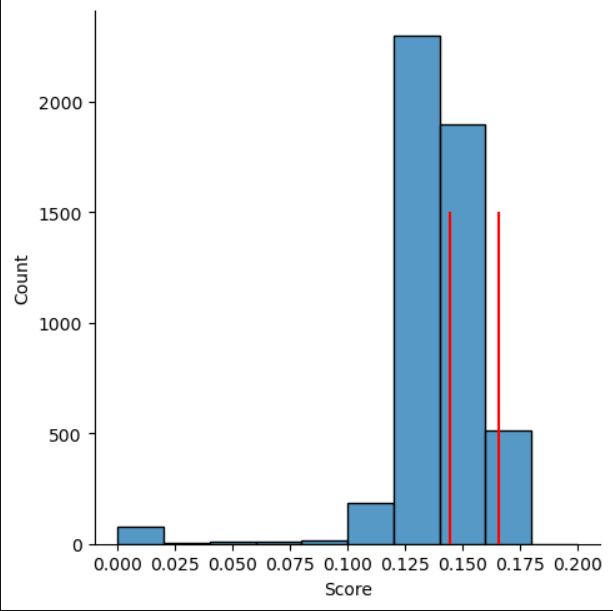